# Food 101 | Kaggle

dataset - `https://www.kaggle.com/dansbecker/food-101/download`

In [ ]:
import tensorflow_datasets as tfds
datasets_list = tfds.list_builders()
print("present" if "food101" in datasets_list else "not present")

In [ ]:
# load in the data
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"],
                                             shuffle_files=True,
                                             as_supervised=True,
                                             with_info=True)

In [ ]:
# Features of Food101 from dataset
ds_info.features

In [ ]:
# Getting the class names
class_names = ds_info.features["label"].names
class_names[:5]

In [ ]:
# Checking a sample from the data
train_data_sample = train_data.take(1)

for image, label in train_data_sample:
  print(f"""
  Class name: {class_names[label.numpy()]}.
  Image shape: {image.shape}.
  Image datatype: {image.dtype}.
  Target class: {label}.
  """)

In [ ]:
import tensorflow as tf
# Checking the min and max values of the image data
tf.reduce_min(image), tf.reduce_max(image)

### Visualizing the data

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.title(class_names[label.numpy()].upper(), fontdict={"fontsize": 24})
plt.axis(False)
plt.show()

In [ ]:
def preprocessing_image(image, label, image_shape=224, normalize=False):
  """
  Converts image datatype to float32
  reshapes the image to image_shape + (3,)
  """
  image = tf.image.resize(image, [image_shape, image_shape])
  if (normalize):
    image /= 255
  return tf.cast(image, tf.float32), label

In [ ]:
# Testing preprocessing_image function
test_image = preprocessing_image(image, label)[0]
print(f"Before:\n{image[:2]},\nshape: {image.shape},\nDatatype: {image.dtype}")
print("\n--------------------------------------------------------------\n")
print(f"After:\n{test_image[:2]},\nshape: {test_image.shape},\nDatatype: {test_image.dtype}")

In [ ]:
# Preparing whole data
train_data = train_data.map(map_func=preprocessing_image,
                            num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.map(map_func=preprocessing_image,
                          num_parallel_calls=tf.data.AUTOTUNE)

 
# turning data into batches
train_data = train_data.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)
test_data = test_data.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)


In [ ]:
train_data

In [ ]:
test_data

In [ ]:
# Creating Tensorboard callback function
import datetime

def tensorboard_callback(dir_name, save_as):
  """
  Creates a tensorboard callback to store log files.

  Filepath:
            dir_name/save_as/current_datatime/
  """

  log_dir = dir_name + "/" + save_as + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tc = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir)
  print(f"Saved tensorboard log files to: {log_dir}")
  return tc

In [ ]:
# Creating ModelCheckpoint callback
cp_path = "ModelcheckPoints/check_point.ckpt"
mcp = tf.keras.callbacks.ModelCheckpoint(cp_path,
                                         monitor="val_acc", # saving the best Valid accuracy model
                                         save_best_only=True,
                                         save_weights_olny=True)

In [ ]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

In [ ]:
mixed_precision.global_policy()

In [ ]:
# setting up base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False # Freezing base_model layers

# Creating functional model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_avg_pooling_2d_layer")(x)
x = tf.keras.layers.Dense(len(class_names))(x)
outputs = tf.keras.layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)

model_1 = tf.keras.Model(inputs, outputs)

In [ ]:
# Compiling Model_1
model_1.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Viewing the summary of the model
model_1.summary()

In [ ]:
# verifying the layers
for layer in model_1.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

In [ ]:
for layer in model_1.layers[1].layers[:10]:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

### Fitting the data into model

In [ ]:
# Fitting data into the model
his_1 = model_1.fit(train_data,
            epochs=5,
            steps_per_epoch=len(train_data),
            validation_data=test_data,
            validation_steps=0.15 * len(test_data),
            callbacks=[tensorboard_callback("drive/MyDrive/Colab Notebooks/tensorboard_callback", "base_model_1"),
                       mcp])

In [ ]:
model_1.save("drive/MyDrive/Colab Notebooks/SavedModel/model_1_base")

### Visualizing model_1 losses

In [111]:

def plot_loss_acc(his, experiment_model):
    loss = his.history["loss"]
    val_loss = his.history["val_loss"]

    epochs = range(len(his.history["loss"]))

    plt.figure(figsize=(8, 6), facecolor="#F9F9F9")
    plt.axes().set_facecolor("#FEFBF3")
    plt.plot(epochs, loss, label="training_loss", c="red")
    plt.plot(epochs, val_loss, label="val_loss", c="black")
    plt.title(experiment_model, "loss graph", fontdict={"fontsize": 25})
    plt.xlabel("Epochs", fontdict={"fontsize": 15})
    plt.ylabel("Loss", fontdict={"fontsize": 15})
    plt.legend()
    plt.show()

    accuracy = his.history["accuracy"]
    val_accuracy = his.history["val_accuracy"]

    plt.figure(figsize=(8, 6), facecolor="#F9F9F9")
    plt.axes().set_facecolor("#FEFBF3")
    plt.plot(epochs, accuracy, label="training_accuracy", c="red")
    plt.plot(epochs, val_accuracy, label="val_accuracy", c="black")
    plt.title(experiment_model,"accuracy graph", fontdict={"fontsize": 25})
    plt.xlabel("Epochs", fontdict={"fontsize": 15})
    plt.ylabel("accuracy", fontdict={"fontsize": 15})
    plt.legend()
    plt.show()

In [ ]:
plot_loss_acc(his_1)

In [49]:
import json
from tqdm.notebook import tqdm

In [ ]:
# Getting labels
def get_labels(label_path):
    with open(label_path) as file:
        return json.load(file)

train_labels = get_labels("Data/food-101/meta/train.json")
test_labels = get_labels("Data/food-101/meta/test.json")

In [ ]:
# Verifying size
print(len(train_labels["churros"]))
print(len(test_labels["churros"]))

In [50]:
import shutil
import os

def copy_images(parent_folder, new_subset, dataset, target_labels):
    print(f"On {dataset} labels__")
    labels = get_labels("Data/food-101/meta/" + dataset + ".json")
    
    for i in target_labels:
        os.makedirs(parent_folder + "/" + new_subset + "/" + dataset + "/" + i, 
                    exist_ok=True)
        
        images_moved = []
        for j in labels[i]:
            # Create original image path and new path
            og_path = parent_folder + "/food-101/images/" + j + ".jpg"
            new_path = parent_folder + "/" + new_subset + "/" + dataset + "/" + j + ".jpg"
            
            # Copy images from old path to new path
            shutil.copy2(og_path, new_path)
            images_moved.append(new_path)
        print(f"Copied {len(images_moved)} images from {dataset} dataset {i} class.")

In [ ]:
parent_folder = "Data"
new_subset = "finished_data"
datasets = ["train", "test"]

classes = []
with open("Data/food-101/meta/classes.txt") as file:
    for line in file.readlines():
        classes.append(line.split("\n")[0])

# Copy training/test images
for i in datasets:
    copy_images(parent_folder=parent_folder,
                new_subset=new_subset,
                dataset=i,
                target_labels=classes)

In [2]:
import tensorflow as tf
train_dir = "Data/finished_data/train/"
test_dir = "Data/finished_data/test/"

In [3]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                image_size=(224, 224),
                                                                label_mode="categorical",
                                                                batch_size=32)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                               label_mode="categorical",
                                                               batch_size=32,
                                                               image_size=(224, 224),
                                                               shuffle=False)

Found 75750 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [4]:
# Recreated
import datetime

def tensorboard_callback(dir_name, save_as):
  """
  Creates a tensorboard callback to store log files.

  Filepath:
            dir_name/save_as/current_datatime/
  """

  log_dir = dir_name + "/" + save_as + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tc = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir)
  print(f"Saved tensorboard log files to: {log_dir}")
  return tc

cp_path = "ModelcheckPoints/check_point.ckpt"
mcp = tf.keras.callbacks.ModelCheckpoint(cp_path,
                                         monitor="val_acc", # saving the best Valid accuracy model
                                         save_best_only=True,
                                         save_weights_olny=True,
                                        verbose=0)

In [13]:
# Setting up base model
base_model = tf.keras.applications.EfficientNetB7(include_top=False)
base_model.trainable = False

# Setting up model architecture with tainable top layers
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_avg_pooling_2d_layer")(x)
outputs = tf.keras.layers.Dense(len(train_data.class_names),
                               activation="softmax",
                               name="output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs)

In [17]:
# Compiling model
model_2.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
               metrics=["accuracy"])

In [18]:
his_2 = model_2.fit(train_data,
                   epochs=5,
                   validation_data=test_data,
                   validation_steps=0.15 * len(test_data),
                   callbacks=[tensorboard_callback("tensorboard_callback", "model_2"),
                             mcp])

Saved tensorboard log files to: tensorboard_callback/model_2/20211207-215445
Epoch 1/5
2368/2368 [==============================] - 1238s 513ms/step - loss: 1.8584 - accuracy: 0.5371 - val_loss: 1.5358 - val_accuracy: 0.6006
Epoch 2/5
2368/2368 [==============================] - 1132s 478ms/step - loss: 1.4035 - accuracy: 0.6363 - val_loss: 1.4311 - val_accuracy: 0.6226
Epoch 3/5
2368/2368 [==============================] - 1141s 482ms/step - loss: 1.2462 - accuracy: 0.6750 - val_loss: 1.3698 - val_accuracy: 0.6387
Epoch 4/5
2368/2368 [==============================] - 1131s 478ms/step - loss: 1.1391 - accuracy: 0.7028 - val_loss: 1.3448 - val_accuracy: 0.6460
Epoch 5/5
2368/2368 [==============================] - 1151s 486ms/step - loss: 1.0564 - accuracy: 0.7230 - val_loss: 1.3454 - val_accuracy: 0.6434


### Visualizing model_2

In [33]:
import os
import random

In [ ]:
def get_partial_data(target_dir, new_dir, partial_per=0.1, random_state=11):
    random.seed(random_state)
    images = [{dir_name: os.listdir(target_dir + dir_name)} for dir_name in os.listdir(target_dir)]
    for i in images:
        for j, k in i.items():
            sample = round(len(k) * partial_per)
            random_img = random.sample(k, sample)
            new_target_dir = new_dir + j
            os.makedirs(new_target_dir)
            image_copied = []
            for file_name in tqdm(random_img):
                og_path = target_dir + k + "/" + file_name
                new_path = new_target_dir + "/" + file_name
                shutil.copy2(og_path, new_path)
                images_copied.append(new_path)
    print("Done")

In [63]:
# Getting all the classes
classes = []
with open("Data/classes.txt") as f:
    for line in f.readlines():
        classes.append(line.split("\n")[0][2:-2]) 
classes[:5]

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare']

In [130]:
train_dir = "data/101_food_classes_10_percent/train/"
test_dir = "data/finished_data/test/"

In [131]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                label_mode="categorical",
                                                                batch_size=32,
                                                                image_size=(224, 224))
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                               label_mode="categorical",
                                                               batch_size=32,
                                                               image_size=(224, 224),
                                                               shuffle=False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [79]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomContrast(0.3),
    tf.keras.layers.experimental.preprocessing.RandomHeight(0.2),
    tf.keras.layers.experimental.preprocessing.RandomWidth(0.2),
])

In [80]:
base_model = tf.keras.applications.EfficientNetB4(include_top=False)
base_model.trainable = False

In [81]:
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name="gap2d")(x)
outputs = tf.keras.layers.Dense(101, activation="softmax", name="output_layer")(x)
model_3 = tf.keras.Model(inputs, outputs)

In [82]:
model_3.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_2 (Sequential)    (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb4 (Functional)  (None, None, None, 1792)  17673823  
_________________________________________________________________
gap2d (GlobalAveragePooling2 (None, 1792)              0         
_________________________________________________________________
output_layer (Dense)         (None, 101)               181093    
Total params: 17,854,916
Trainable params: 181,093
Non-trainable params: 17,673,823
_________________________________________________________________


In [83]:
import datetime

def tensorboard_callback(dir_name, save_as):
  log_dir = dir_name + "/" + save_as + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tc = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir)
  print(f"Saved tensorboard log files to: {log_dir}")
  return tc

cp_path = "ModelcheckPoints/check_point.ckpt"
mcp = tf.keras.callbacks.ModelCheckpoint(cp_path,
                                         monitor="val_acc", # saving the best Valid accuracy model
                                         save_best_only=True,
                                         save_weights_olny=True,
                                        verbose=0)

In [84]:
model_3.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

In [85]:
his_3 = model_3.fit(train_data,
                   epochs=5,
                   steps_per_epoch=len(train_data),
                   validation_data=test_data,
                   validation_steps=0.25 * len(test_data),
                   callbacks=[tensorboard_callback("tensorboard_callback", "model_3"),
                             mcp])

Saved tensorboard log files to: tensorboard_callback/model_3/20211208-092512
Epoch 1/5
237/237 [==============================] - 192s 758ms/step - loss: 3.1216 - accuracy: 0.3160 - val_loss: 2.4035 - val_accuracy: 0.4340
Epoch 2/5
237/237 [==============================] - 142s 601ms/step - loss: 1.9954 - accuracy: 0.5300 - val_loss: 2.0886 - val_accuracy: 0.4752
Epoch 3/5
237/237 [==============================] - 133s 563ms/step - loss: 1.6427 - accuracy: 0.6005 - val_loss: 1.9571 - val_accuracy: 0.5017
Epoch 4/5
237/237 [==============================] - 126s 532ms/step - loss: 1.4328 - accuracy: 0.6425 - val_loss: 1.8888 - val_accuracy: 0.5137
Epoch 5/5
237/237 [==============================] - 123s 517ms/step - loss: 1.2733 - accuracy: 0.6900 - val_loss: 1.8327 - val_accuracy: 0.5281


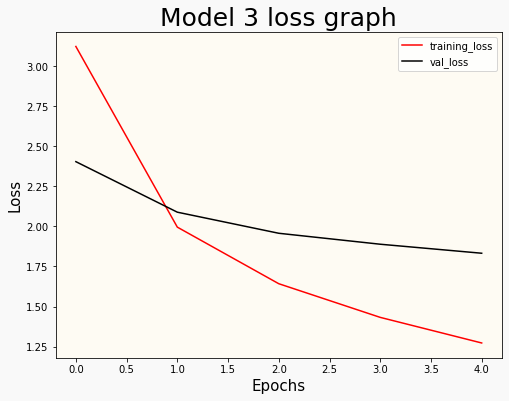

In [115]:
loss = his_3.history["loss"]
val_loss = his_3.history["val_loss"]

epochs = range(len(his_3.history["loss"]))
plt.figure(figsize=(8, 6), facecolor="#F9F9F9")
plt.axes().set_facecolor("#FEFBF3")
plt.plot(epochs, loss, label="training_loss", c="red")
plt.plot(epochs, val_loss, label="val_loss", c="black")
plt.title("Model 3 loss graph", fontdict={"fontsize": 25})
plt.xlabel("Epochs", fontdict={"fontsize": 15})
plt.ylabel("Loss", fontdict={"fontsize": 15})
plt.legend()
plt.show()

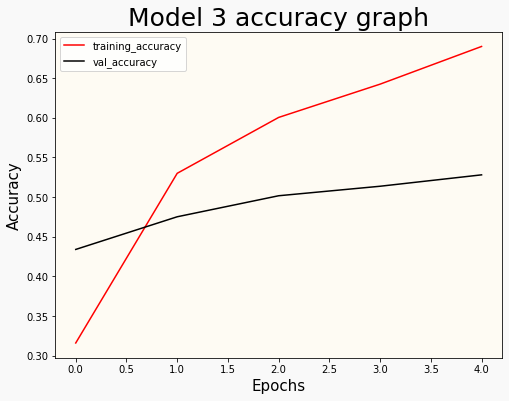

In [117]:
accuracy = his_3.history["accuracy"]
val_accuracy = his_3.history["val_accuracy"]

plt.figure(figsize=(8, 6), facecolor="#F9F9F9")
plt.axes().set_facecolor("#FEFBF3")
plt.plot(epochs, accuracy, label="training_accuracy", c="red")
plt.plot(epochs, val_accuracy, label="val_accuracy", c="black")
plt.title("Model 3 accuracy graph", fontdict={"fontsize": 25})
plt.xlabel("Epochs", fontdict={"fontsize": 15})
plt.ylabel("Accuracy", fontdict={"fontsize": 15})
plt.legend()
plt.show()

## Training Best model

In [143]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

In [144]:
data_aug = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomContrast(0.5),
])

In [145]:
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_aug(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = tf.keras.layers.Flatten()(x)
outputs = tf.keras.layers.Dense(101, activation="softmax", name="output_layer")(x)
model_4 = tf.keras.Model(inputs, outputs)

In [146]:
model_4.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

In [147]:
model_4.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_4 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
pooling_layer (GlobalAverage (None, 1280)              0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 101)               129381    
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
___________________________________________

In [148]:
his_4 = model_4.fit(train_data, epochs=10,
                   validation_data=test_data,
                   validation_steps=len(test_data) * 0.15,
                   callbacks=[tensorboard_callback("tensorboard_callback", "model 4"),
                             mcp])

Saved tensorboard log files to: tensorboard_callback/model 4/20211208-101708
Epoch 1/10
237/237 [==============================] - 49s 180ms/step - loss: 3.1887 - accuracy: 0.3089 - val_loss: 2.4055 - val_accuracy: 0.4695
Epoch 2/10
237/237 [==============================] - 33s 138ms/step - loss: 1.9257 - accuracy: 0.5653 - val_loss: 2.0177 - val_accuracy: 0.5137
Epoch 3/10
237/237 [==============================] - 33s 138ms/step - loss: 1.5341 - accuracy: 0.6422 - val_loss: 1.8704 - val_accuracy: 0.5239
Epoch 4/10
237/237 [==============================] - 33s 139ms/step - loss: 1.2920 - accuracy: 0.6978 - val_loss: 1.7731 - val_accuracy: 0.5404
Epoch 5/10
237/237 [==============================] - 33s 137ms/step - loss: 1.1133 - accuracy: 0.7468 - val_loss: 1.7222 - val_accuracy: 0.5491
Epoch 6/10
237/237 [==============================] - 32s 135ms/step - loss: 0.9957 - accuracy: 0.7762 - val_loss: 1.6998 - val_accuracy: 0.5504
Epoch 7/10
237/237 [==============================] -

In [149]:
base_model.trainable = True
for i in base_model.layers[:-10]:
    i.trainable = False

In [150]:
model_4.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
               metrics=["accuracy"])

In [151]:
his_4 = model_4.fit(train_data, epochs=10,
                   validation_data=test_data,
                   validation_steps=len(test_data) * 0.15,
                   callbacks=[tensorboard_callback("tensorboard_callback", "model_4_2"),
                             mcp])

Saved tensorboard log files to: tensorboard_callback/model_4_2/20211208-102431
Epoch 1/10


D:\AnaConda\envs\tensorflow\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


237/237 [==============================] - 54s 198ms/step - loss: 0.4552 - accuracy: 0.8921 - val_loss: 1.7773 - val_accuracy: 0.5604
Epoch 2/10
237/237 [==============================] - 33s 139ms/step - loss: 0.3473 - accuracy: 0.9200 - val_loss: 1.8237 - val_accuracy: 0.5609
Epoch 3/10
237/237 [==============================] - 33s 139ms/step - loss: 0.2902 - accuracy: 0.9361 - val_loss: 1.8546 - val_accuracy: 0.5675
Epoch 4/10
237/237 [==============================] - 33s 139ms/step - loss: 0.2177 - accuracy: 0.9551 - val_loss: 1.9026 - val_accuracy: 0.5649
Epoch 5/10
237/237 [==============================] - 33s 138ms/step - loss: 0.1674 - accuracy: 0.9719 - val_loss: 1.9927 - val_accuracy: 0.5520
Epoch 6/10
237/237 [==============================] - 33s 140ms/step - loss: 0.1501 - accuracy: 0.9741 - val_loss: 2.0620 - val_accuracy: 0.5507
Epoch 7/10
237/237 [==============================] - 33s 139ms/step - loss: 0.1105 - accuracy: 0.9840 - val_loss: 2.0837 - val_accuracy: 0.5

In [152]:
model_4.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_4 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
pooling_layer (GlobalAverage (None, 1280)              0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 101)               129381    
Total params: 4,178,952
Trainable params: 1,022,613
Non-trainable params: 3,156,339
_________________________________________

In [153]:
base_model.trainable = True

In [154]:
train_dir = "data/finished_data/train/"
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                label_mode="categorical",
                                                                batch_size=32,
                                                                image_size=(224, 224))

Found 75750 files belonging to 101 classes.


In [155]:
model_4.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
               metrics=["accuracy"])

In [ ]:
his_4_3 = model_4.fit(train_data, epochs=10,
                   validation_data=test_data,
                   validation_steps=len(test_data) * 0.15)

In [159]:
model_2.evaluate(test_data)

790/790 [==============================] - 367s 461ms/step - loss: 1.1876 - accuracy: 0.6832


[1.187568187713623, 0.6831682920455933]

In [160]:
model_3.evaluate(test_data)

790/790 [==============================] - 162s 200ms/step - loss: 1.1986 - accuracy: 0.6825


[1.1986374855041504, 0.6825346350669861]

In [161]:
model_4.evaluate(test_data)

790/790 [==============================] - 73s 92ms/step - loss: 0.7891 - accuracy: 0.7838


[0.7891407012939453, 0.7838019728660583]